In [1]:
from pymol import cmd
from rdkit import Chem
import py3Dmol

from openbabel import pybel

import sys, os, random
sys.path.insert(1, 'utilities/')

from utils import get_inplace_rmsd, get_scaffold_based_conformers

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [2]:
os.chdir('test/Scaffold_based_Docking/')

In [3]:
cmd.fetch(code='1B38',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='ATP',selection='resn ATP')
cmd.save(filename='1B38_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1B38_ATP.sdf',format='sdf',selection='ATP')
cmd.delete('all')

In [10]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1B38_clean.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open('1B38_ATP.sdf','r').read(),format='sdf')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
mol= [m for m in pybel.readfile(filename='1B38_ATP.sdf',format='sdf')][0]
mol.addh()
out=pybel.Outputfile(filename='1B38_ATP_H.sdf',format='sdf',overwrite=True)
out.write(mol)
out.close()

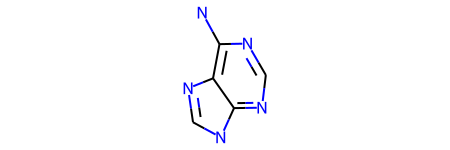

In [7]:
ATP=Chem.SDMolSupplier('1B38_ATP_H.sdf',False)[0]
ade_map=ATP.GetSubstructMatch(Chem.MolFromSmarts('[#7]-[#6]-1=[#6]-2-[#7]=[#6]-[#7]-[#6]-2=[#7]-[#6]=[#7]-1'))
scaffold=Chem.EditableMol(ATP)
scaffold_out=Chem.SDWriter('Adenine.sdf')
for atom in reversed(ATP.GetAtoms()):
    if atom.GetIdx() not in ade_map:
        scaffold.RemoveAtom(atom.GetIdx())
        s=scaffold.GetMol()
scaffold_out.write(s)
s

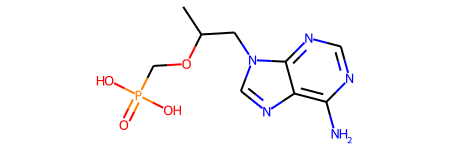

In [8]:
Apropovir=Chem.MolFromSmiles('CC(CN1C=NC2=C(N=CN=C21)N)OCP(=O)(O)O')
Apropovir

In [9]:
get_scaffold_based_conformers(smiles='CC(CN1C=NC2=C(N=CN=C21)N)OCP(=O)(O)O',anchor='Adenine.sdf',num_confs=200,rmsd_threshold=0.75,output='Confs.sdf')

In [15]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

confs=Chem.SDMolSupplier('Confs.sdf')
for c in list(confs):
    c_1=Chem.MolToMolBlock(c)
    view.addModel(c_1,'mol')
    z= view.getModel()
    z.setStyle({},{'stick':{'colorCarbon':'gray','radius':0.1,'opacity':1}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
!../../bin/lepro_linux_x86 {'1B38_clean.pdb'}

os.rename('pro.pdb','1B38_clean_H.pdb')

In [28]:
!../../bin/smina -r {'1B38_clean_H.pdb'} -l {'Confs.sdf'} -o {'Smina.sdf'} --minimize >> {'smina.log'}

candidates=Chem.SDWriter('Cans.sdf')
results=Chem.SDMolSupplier('Smina.sdf')
scaffold=Chem.SDMolSupplier('Adenine.sdf')[0]
for res in results:
    rmsd= get_inplace_rmsd (scaffold,res)
    if rmsd <= 1 and float(res.GetProp('minimizedAffinity')) < 0:
        res.SetProp('RMSDvsScaffold',str(rmsd))
        candidates.write(res)
candidates.close()

In [30]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1B38_clean.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open('1B38_ATP.sdf','r').read(),format='sdf')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

confs=Chem.SDMolSupplier('Cans.sdf')
for c in list(confs)[:10]:
    c_1=Chem.MolToMolBlock(c)
    print(c.GetProp('_Name'),'Score: {} | RMSD vs Scaffold: {}'.format(c.GetProp('minimizedAffinity'),c.GetProp('RMSDvsScaffold')))
    view.addModel(c_1,'mol')
    z= view.getModel()
    z.setStyle({},{'stick':{'colorCarbon':'gray','radius':0.1,'opacity':1}})

view.zoomTo()
view.show()

 Score: -5.97664 | RMSD vs Scaffold: 0.4523237137272379
 Score: -0.07111 | RMSD vs Scaffold: 0.7638085165799083
 Score: -5.71039 | RMSD vs Scaffold: 0.5227661054429604
 Score: -5.83819 | RMSD vs Scaffold: 0.38256257527364096
 Score: -5.09564 | RMSD vs Scaffold: 0.6511503413191146
 Score: -5.74657 | RMSD vs Scaffold: 0.8141302186996873
 Score: -5.22347 | RMSD vs Scaffold: 0.6442026730773478
 Score: -6.29610 | RMSD vs Scaffold: 0.3712376570338742
 Score: -6.24476 | RMSD vs Scaffold: 0.37265014155371007
 Score: -5.44178 | RMSD vs Scaffold: 0.7177091569709836


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol